In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

2024-06-02 20:22:36.240635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 20:22:36.336320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 20:22:36.338190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 20:22:37.943516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the dataset
data = pd.read_excel('data/Data_.xlsx')

# Split the data into features (X) and target (y)
X = data.drop(columns=['EC'])
y = data['EC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Check the shapes of the training and testing sets
print(X_train_lstm.shape, X_test_lstm.shape, y_train.shape, y_test.shape)


(57, 1, 5) (15, 1, 5) (57,) (15,)


In [3]:
# Define the LSTM model structure
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


2024-06-02 20:22:39.522816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
# Define a custom callback to print loss and accuracy per epoch
print_epoch_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch {epoch+1}: Loss = {logs['loss']:.4f}, MAE = {logs['mae']:.4f}, "
        f"Val Loss = {logs['val_loss']:.4f}, Val MAE = {logs['val_mae']:.4f}"
    )
)

# Train the model with the custom callback
history_lstm = lstm_model.fit(
    X_train_lstm, y_train, epochs=50000, batch_size=10, validation_split=0.2, verbose=0,
    callbacks=[print_epoch_callback]
)


Epoch 1: Loss = 40609500.0000, MAE = 5823.1016, Val Loss = 57944780.0000, Val MAE = 6730.6265
Epoch 2: Loss = 40609224.0000, MAE = 5823.0781, Val Loss = 57944372.0000, Val MAE = 6730.5991
Epoch 3: Loss = 40608828.0000, MAE = 5823.0483, Val Loss = 57943872.0000, Val MAE = 6730.5645
Epoch 4: Loss = 40608388.0000, MAE = 5823.0127, Val Loss = 57943212.0000, Val MAE = 6730.5210
Epoch 5: Loss = 40607812.0000, MAE = 5822.9658, Val Loss = 57942332.0000, Val MAE = 6730.4624
Epoch 6: Loss = 40607000.0000, MAE = 5822.9028, Val Loss = 57941132.0000, Val MAE = 6730.3848
Epoch 7: Loss = 40605904.0000, MAE = 5822.8193, Val Loss = 57939440.0000, Val MAE = 6730.2773
Epoch 8: Loss = 40604348.0000, MAE = 5822.7012, Val Loss = 57937044.0000, Val MAE = 6730.1270
Epoch 9: Loss = 40602232.0000, MAE = 5822.5400, Val Loss = 57933696.0000, Val MAE = 6729.9165
Epoch 10: Loss = 40599032.0000, MAE = 5822.3096, Val Loss = 57929004.0000, Val MAE = 6729.6255
Epoch 11: Loss = 40594796.0000, MAE = 5821.9941, Val Loss =

In [5]:
# Save the model
lstm_model.save('models/lstm_model.h5')


/home/wakili/anaconda3/envs/xaienv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_train_pred_lstm = lstm_model.predict(X_train_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
print(f'MSE: {mse_lstm}, R²: {r2_lstm}')


2/2 [==============================] - 0s 3ms/step
MSE: 211902.99079294462, R²: 0.9581946461910724


In [15]:
# Export actual vs. predicted values to CSV and Excel files
results_lstm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lstm.flatten()})
train_results_lstm = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_lstm.flatten()})



# Save to Excel
results_lstm.to_excel('results/actual_vs_predicted_lstm_test.xlsx', index=False)
train_results_lstm.to_excel('results/actual_vs_predicted_lstm_train.xlsx', index=False) 

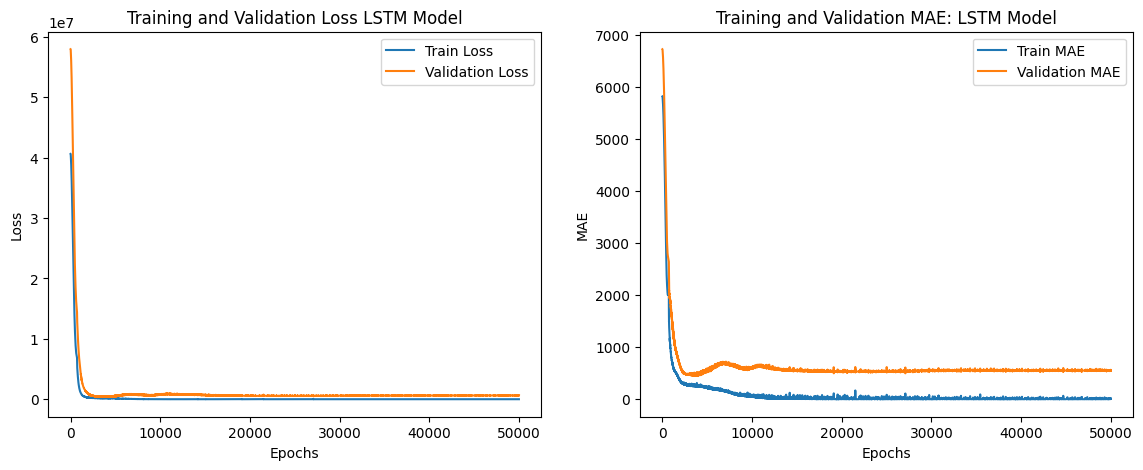

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

# Plot training loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss LSTM Model')

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE: LSTM Model') 

plt.show()
plt.savefig('results/training_validation_lstm.png')


In [9]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f'Mean Absolute Error: {mae_lstm}')


Mean Absolute Error: 312.5847805989584


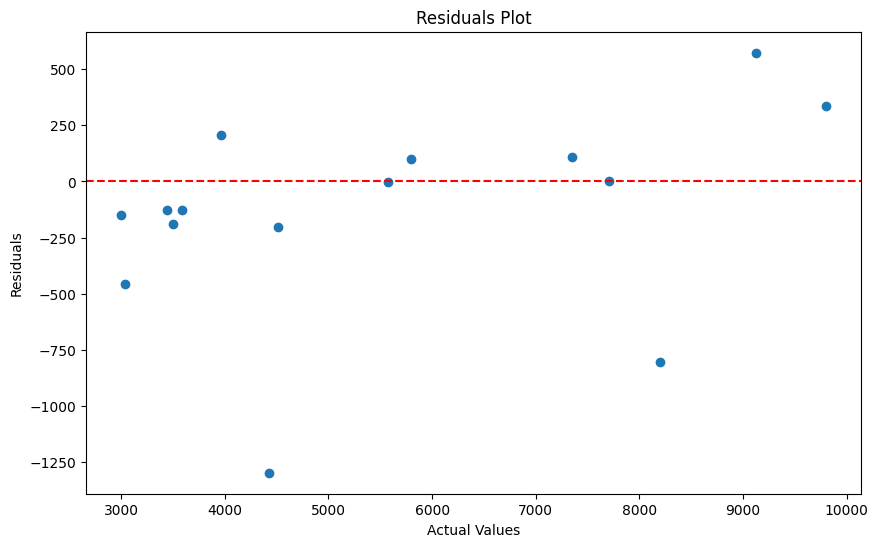

In [10]:
# Plot residuals
residuals_lstm = y_test - y_pred_lstm.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_lstm)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()
